In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [4]:
qm9 = pd.read_csv("qm_ext_plus.csv")
qm9.index = qm9["Unnamed: 0"]
qm9.drop(columns=["Unnamed: 0"], inplace=True)
qm9["mol"] = qm9["smiles"].apply(Chem.MolFromSmiles)

In [5]:
qm9.dropna()

,smiles,mu,alpha,homo,lumo,gap,zpve,cv,u0,u298,h298,g298,num_atoms,mol
Unnamed: 0,,,,,,,,,,,,,,
0,C,0.0000,13.210000,-0.387700,0.117100,0.504800,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597,1,<rdkit.Chem.rdchem.Mol object at 0x7fe887f5df00>
1,N,1.6256,9.460000,-0.257000,0.082900,0.339900,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961,1,<rdkit.Chem.rdchem.Mol object at 0x7fe887f5d780>
2,O,1.8511,6.310000,-0.292800,0.068700,0.361500,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349,1,<rdkit.Chem.rdchem.Mol object at 0x7fe887f5de40>
3,C#C,0.0000,16.280000,-0.284500,0.050600,0.335100,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429,2,<rdkit.Chem.rdchem.Mol object at 0x7fe887f5dcc0>
4,C#N,2.8937,12.990000,-0.360400,0.019100,0.379600,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246,2,<rdkit.Chem.rdchem.Mol object at 0x7fe887f5d600>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155584,CCCCCC(Cl)(Cl)Cl,1.6998,91.438949,-0.437290,0.151861,0.589151,0.160407,39.627,-1612.899018,-1615.123029,-1612.726294,-1612.777780,9,<rdkit.Chem.rdchem.Mol object at 0x7fe866e9f1c0>
155585,CCCNCC(Cl)(Cl)Cl,1.0758,88.241518,-0.375428,0.153217,0.528645,0.149152,39.102,-1628.886186,-1631.151460,-1628.724865,-1628.775694,9,<rdkit.Chem.rdchem.Mol object at 0x7fe866e9f220>
155586,CCCOCC(Cl)(Cl)Cl,5.6070,83.982178,-0.429966,0.153852,0.583818,0.136714,37.858,-1648.698216,-1651.009167,-1648.549519,-1648.600105,9,<rdkit.Chem.rdchem.Mol object at 0x7fe866e9f280>


In [6]:
db_conf = pd.read_parquet("db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [7]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [8]:
db_conf = db_conf.drop(index=na_ind)
db_conf = db_conf.reset_index(drop=True)

# Labels Encoding

In [9]:
from sklearn import preprocessing

In [10]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [11]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [12]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7fe8648cf7c0>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7fe86416bfa0>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7fe86416be80>,0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7fe86416bee0>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7fe86416be20>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7fe864150580>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7fe8641505e0>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7fe864150640>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7fe8641506a0>,0


In [13]:
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
db_conf["num_atoms"] = db_conf["mol"].apply(lambda x: x.GetNumAtoms())

# Generate FQDs

In [14]:
db_conf_filled = db_conf.copy()

In [15]:
qprops = "mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv".split(",")

In [16]:
import statistics
def calculate_FQDs(indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        ret.append(patterns_db[quantum_property][i])
    return statistics.mean(ret)

def calculate_FQDs_quant(mol, indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        n_occurences = len(list(mol.GetSubstructMatch(patterns_db["mol"][i])))
        ret.append(patterns_db[quantum_property][i] * n_occurences)
    return statistics.mean(ret)

In [17]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}"] = db_conf_filled[f"FQD_{num}"].apply(calculate_FQDs, patterns_db=qm9, quantum_property=prop)

In [18]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

# Quant FQDs

In [19]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}"] = db_conf_filled["mol"].apply(lambda x: calculate_FQDs_quant(x,
                                                                          indices=db_conf_filled[db_conf_filled["mol"]==x][f"FQD_{num}"].iloc[0],
                                                                          patterns_db=qm9,
                                                                          quantum_property=prop)
                                                                         )

In [20]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"quant_FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

In [21]:
nan_cols = db_conf.iloc[:,4:12].isna()

In [22]:
db_conf_filled = db_conf_filled.fillna(0)

In [23]:
nan_cols_colnames = [f"{x}_nan" for x in nan_cols]
nan_cols.columns = nan_cols_colnames
fqd_columns = list(db_conf_filled.columns[14:])
nan_cols

,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,True,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,True,False
4,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
834,True,True,True,False,False,False,False,False
835,True,True,True,False,False,False,False,False
836,False,False,False,False,False,False,False,False
837,False,False,False,False,False,False,False,False


In [24]:
db_conf_filled = pd.concat([db_conf_filled, nan_cols], axis=1)
db_conf_filled

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,quant_FQD_8_cv_per_atom,quant_FQD_9_cv_per_atom,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,25.429333,34.071000,True,True,True,False,False,False,False,False
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,8.696556,11.601875,False,False,False,False,False,False,False,False
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,13.616348,17.217000,False,False,False,False,False,False,False,False
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,24.767000,0.000000,True,True,True,False,False,False,True,False
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,23.248000,23.053500,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,23.407333,30.375750,True,True,True,False,False,False,False,False
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,16.680667,21.668250,True,True,True,False,False,False,False,False
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,8.633506,10.959239,False,False,False,False,False,False,False,False
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,18.348571,20.109643,False,False,False,False,False,False,False,False


# Generate RDKit descriptors

In [25]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = []
maccs_keys = []
morgan_fp = []
for mol in db_conf["mol"]:
    descriptors.append(calculator.CalcDescriptors(mol))
    maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp.append(pd.Series(fp_vect))
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(len(maccs_keys[0]))] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf_filled.columns) + cols_rdkit
dat3 = pd.concat([db_conf_filled.reset_index(drop=True), pd.DataFrame(descriptors), pd.DataFrame(maccs_keys), pd.DataFrame(morgan_fp)], axis=1)
dat3.columns = cols


In [26]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
dat3.columns[14:]

Index(['quant_FQD_2_mu', 'quant_FQD_3_mu', 'quant_FQD_4_mu', 'quant_FQD_5_mu',
       'quant_FQD_6_mu', 'quant_FQD_7_mu', 'quant_FQD_8_mu', 'quant_FQD_9_mu',
       'quant_FQD_2_alpha', 'quant_FQD_3_alpha',
       ...
       'MorganFP_bit_2038', 'MorganFP_bit_2039', 'MorganFP_bit_2040',
       'MorganFP_bit_2041', 'MorganFP_bit_2042', 'MorganFP_bit_2043',
       'MorganFP_bit_2044', 'MorganFP_bit_2045', 'MorganFP_bit_2046',
       'MorganFP_bit_2047'],
      dtype='object', length=2607)

# Fill data with 0s

In [28]:
x = dat3.iloc[:, 14:].fillna(0)
y = dat3["class_encoded"]

# OOB dataset creation

In [29]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [30]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [31]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [32]:
x, y = res_x, res_y

In [33]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Balancing data

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer

In [53]:
from sklearn.metrics import f1_score, balanced_accuracy_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [54]:
import lightgbm as lgb

In [41]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = []
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
        ]),
                                     fqd_columns+descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score = scoring_callable(Y.iloc[validation_index], model.predict(x_val))
        scores.append(score)
    
    return np.array(scores).mean()

In [42]:
""""lgb__max_depth": range(3, 12),
"lgb__n_estimators": [200, 350, 500, 1000],
"lgb__learning_rate": [0.01, 0.05, 0.1, 0.15],
"lgb__reg_alpha": range(0, 15),
"lgb__reg_lambda": range(0,15)"""

import itertools
params = list(itertools.product(range(3, 12),
        [200, 350, 500, 1000],
        [0.01, 0.05, 0.1, 0.15],
        range(0, 15),
        range(0,15)))
result = pd.DataFrame(params)
result.columns = "max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda".split(",")


In [43]:
scores = []
for max_depth, n_estimators, learning_rate, reg_alpha, reg_lambda in params:
    model = lgb.LGBMClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=1
        )
    scores.append(my_score(model, 5, f1_score, x, y))

result["f_score"] = scores

KeyboardInterrupt: 

In [44]:
result.to_csv("hyperparams_combined_zeros_results.csv")
# result = pd.read_csv("hyperparams_combined_zeros_results.csv")

In [47]:
result[result["f_score"]==result["f_score"].max()]

,Unnamed: 0,max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda,f_score
14627,14627,7,200,0.05,0,2,0.766357


# OOB validation

## Scale and apply PCA to training dataset

In [48]:
oversampler = RandomOverSampler(random_state=1)
preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
        ]
        ),
                                     fqd_columns+descriptors_names)], remainder="passthrough")

oob_scores = []
bal_acc_scores = []
preds = []
xx, yy = oversampler.fit_resample(x, y)
xx = preprocessor.fit_transform(xx)
for i in range(5):
    model = lgb.LGBMClassifier(
        max_depth=7,
        n_estimators=200,
        learning_rate=0.05,
        reg_alpha=0,
        reg_lambda=2,
        random_state=60+i
        )
    model.fit(xx, yy)
    x_val = oob_x
    x_val = preprocessor.transform(x_val)
    pred = model.predict(x_val)
    score = f1_score(oob_y, pred)
    preds.append(pred)
    oob_scores.append(score)
    score = balanced_accuracy_score(oob_y, pred)
    bal_acc_scores.append(score)

In [49]:
oob_scores

[0.7285714285714284,
 0.7285714285714284,
 0.7285714285714284,
 0.7285714285714284,
 0.7285714285714284]

In [52]:
bal_acc_scores

[0.8285816108339272,
 0.8285816108339272,
 0.8285816108339272,
 0.8285816108339272,
 0.8285816108339272]

## LGBMC
With tuned hyperparameters

In [53]:
from sklearn.metrics import confusion_matrix
conf_mats = [confusion_matrix(le.inverse_transform(oob_y), le.inverse_transform(pred)) for pred in preds]
conf_mats

[array([[224,  20],
        [ 18,  51]]),
 array([[224,  20],
        [ 18,  51]]),
 array([[224,  20],
        [ 18,  51]]),
 array([[224,  20],
        [ 18,  51]]),
 array([[224,  20],
        [ 18,  51]])]

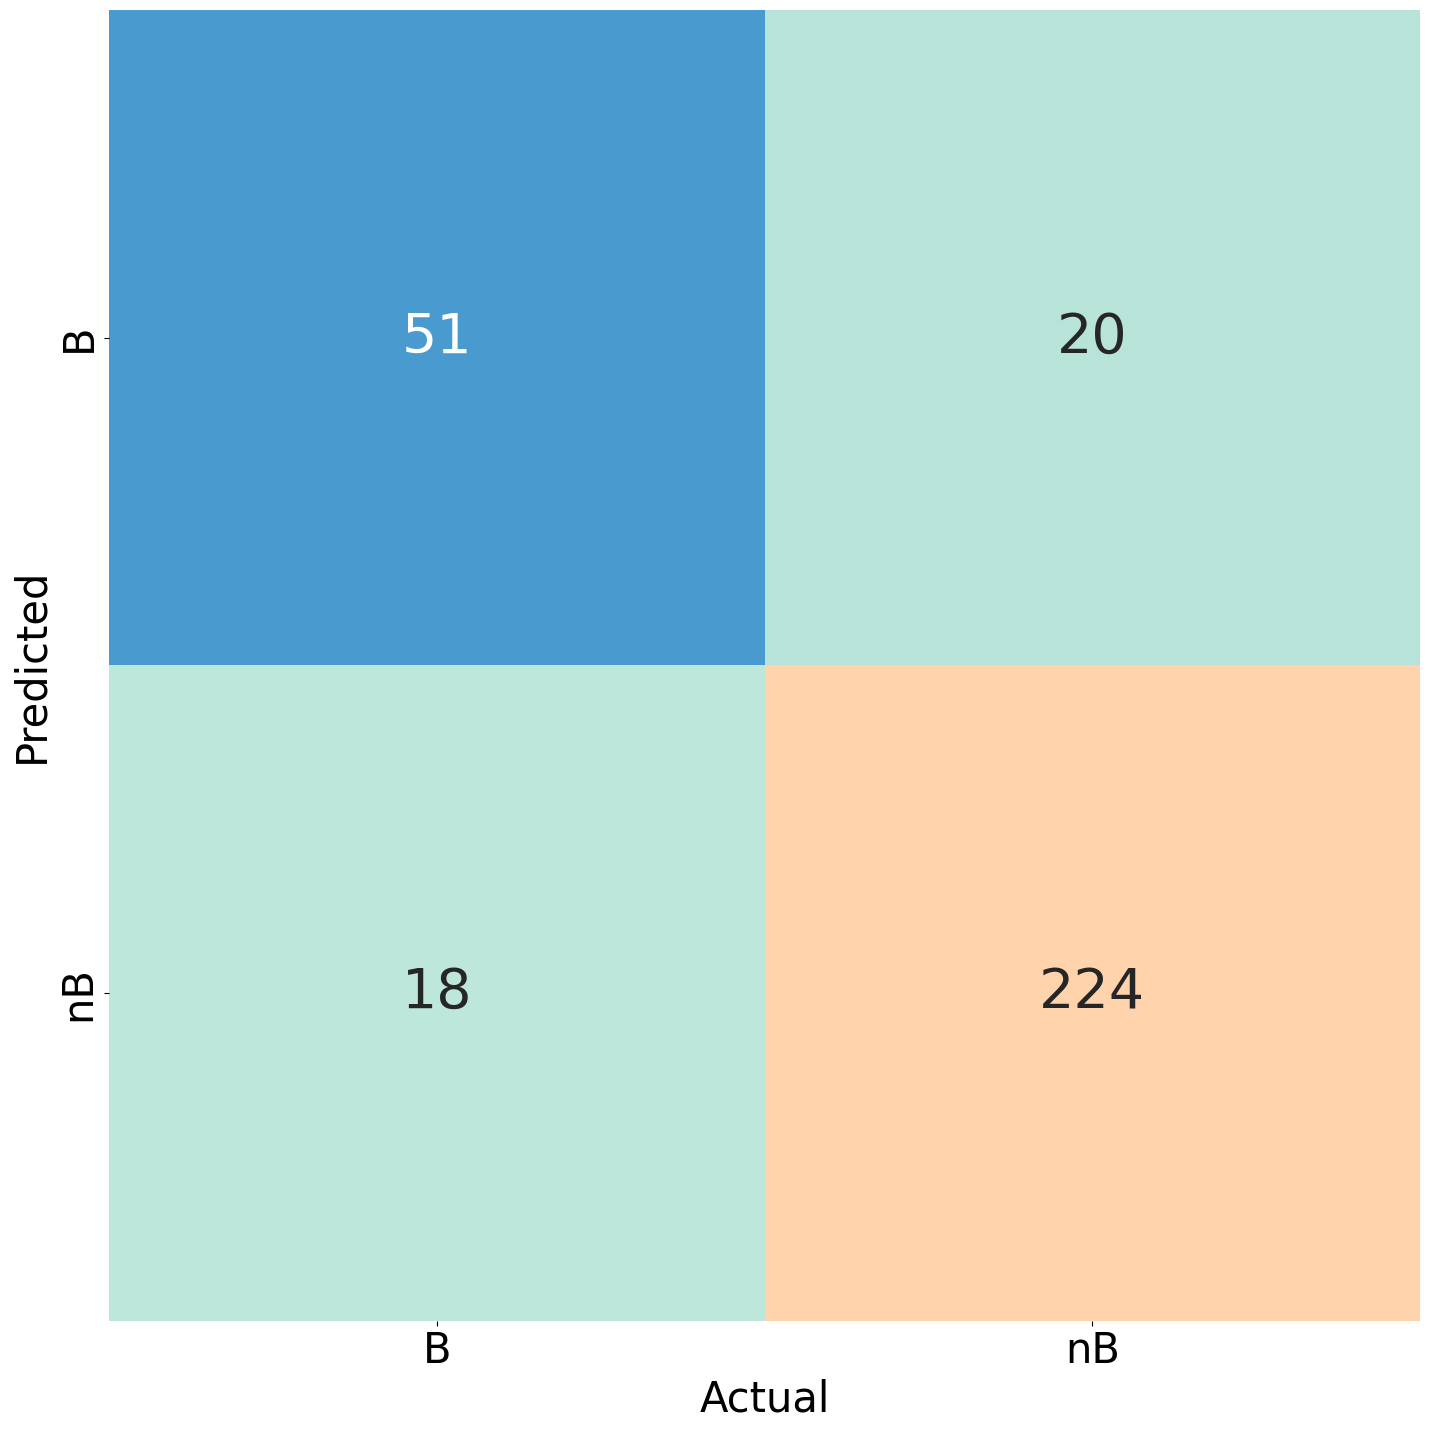

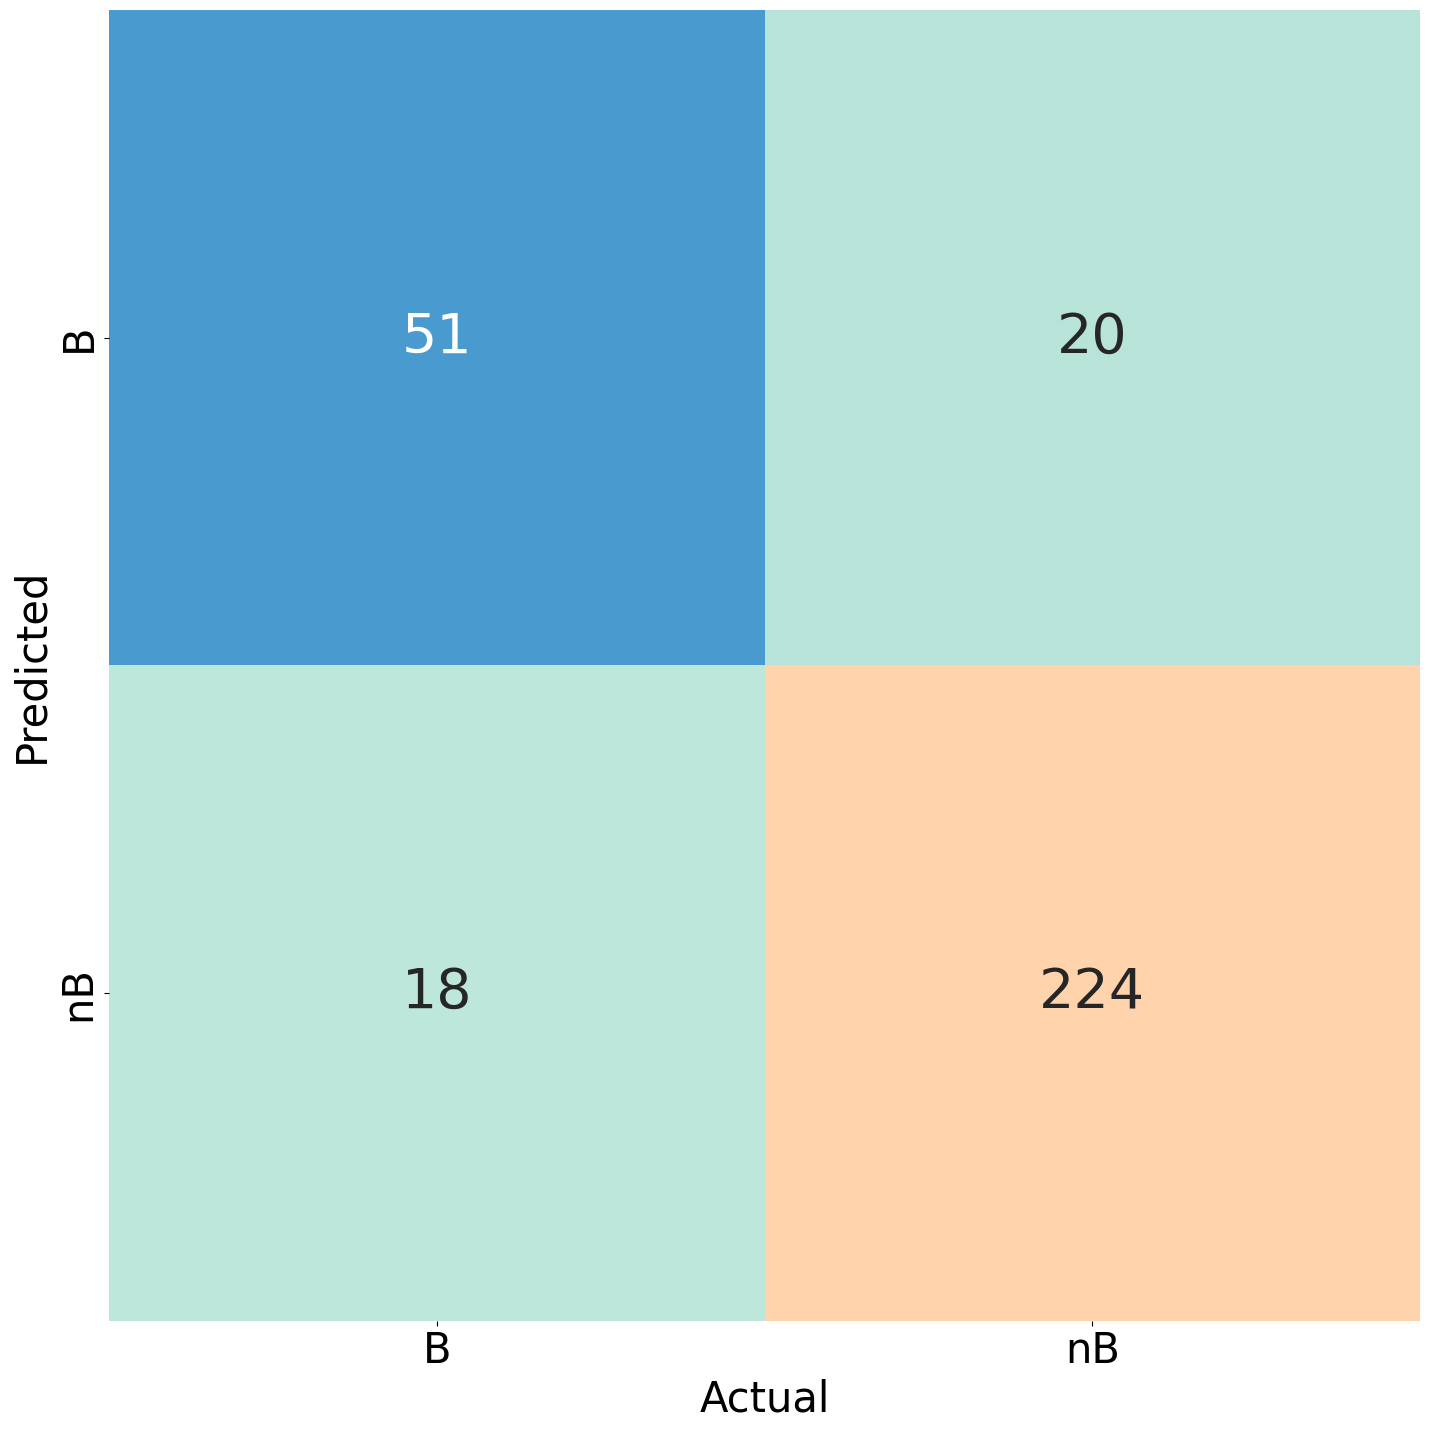

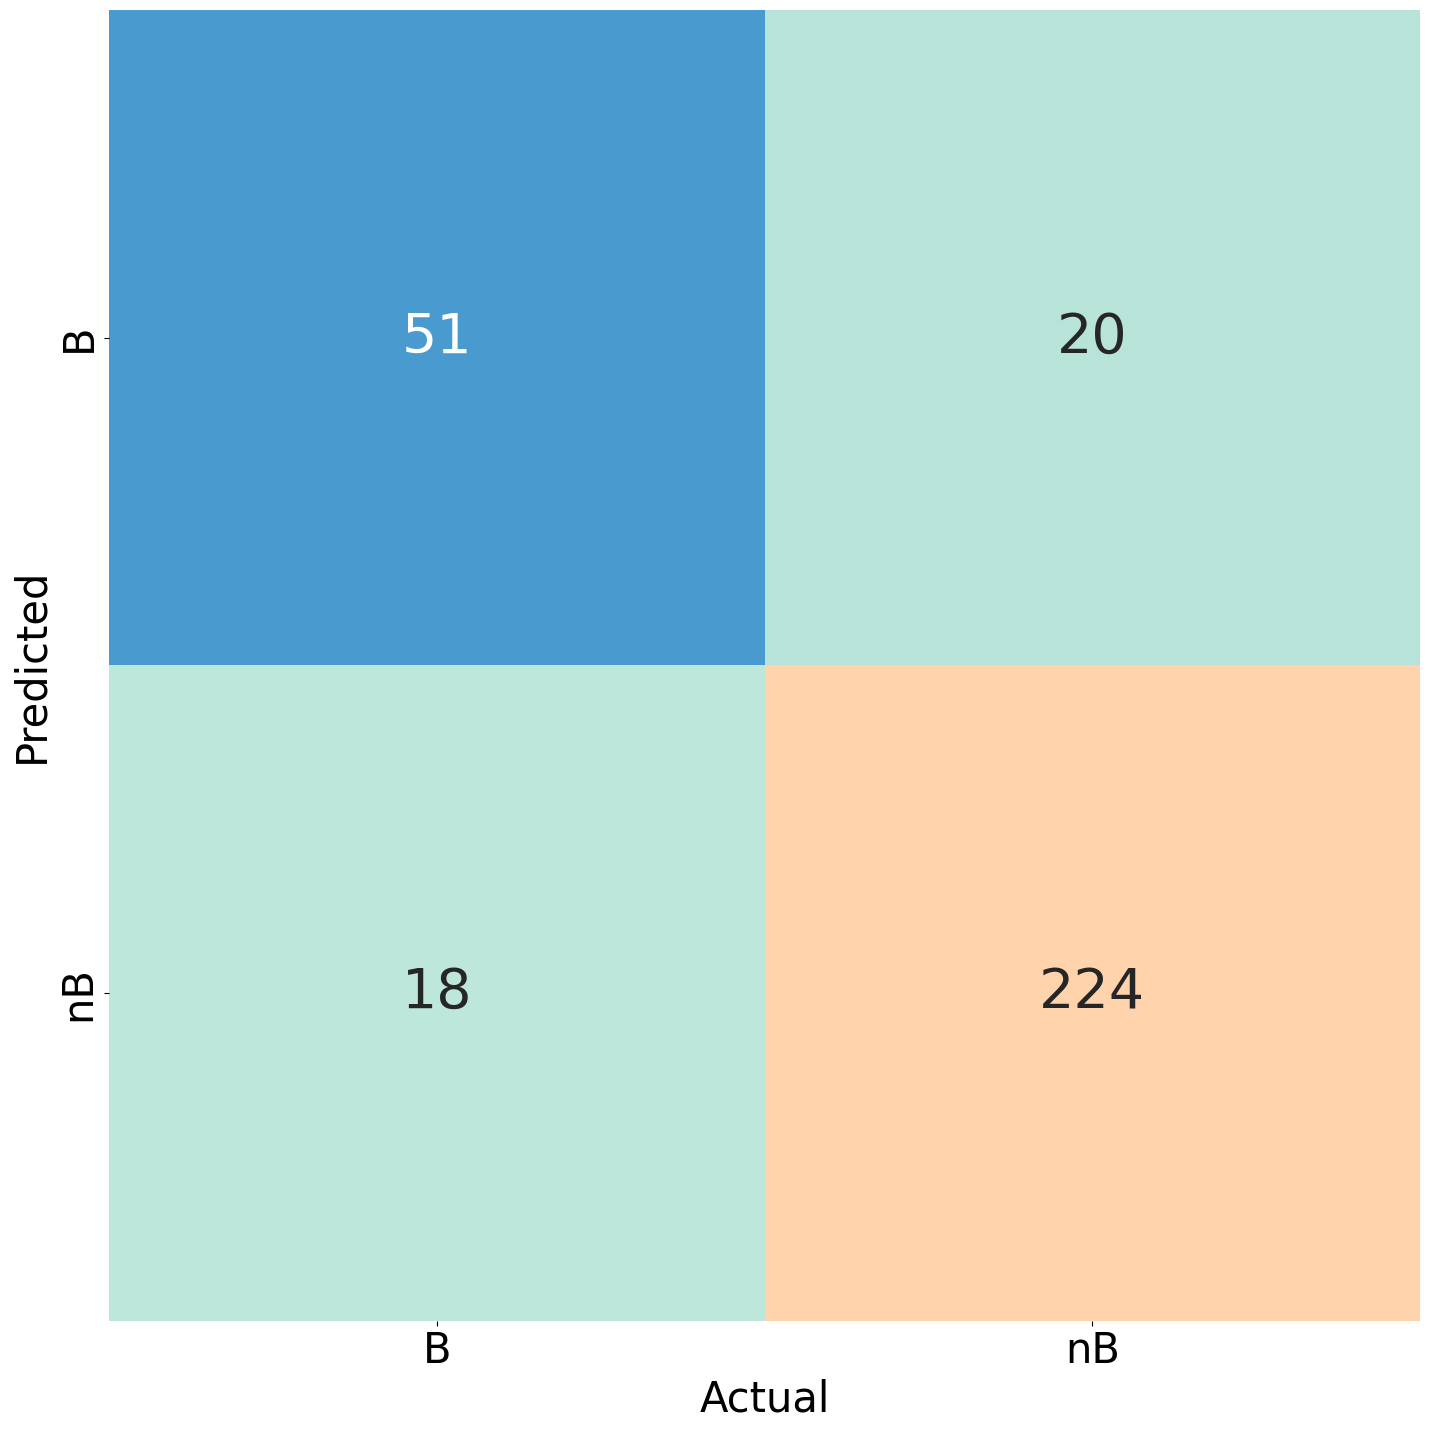

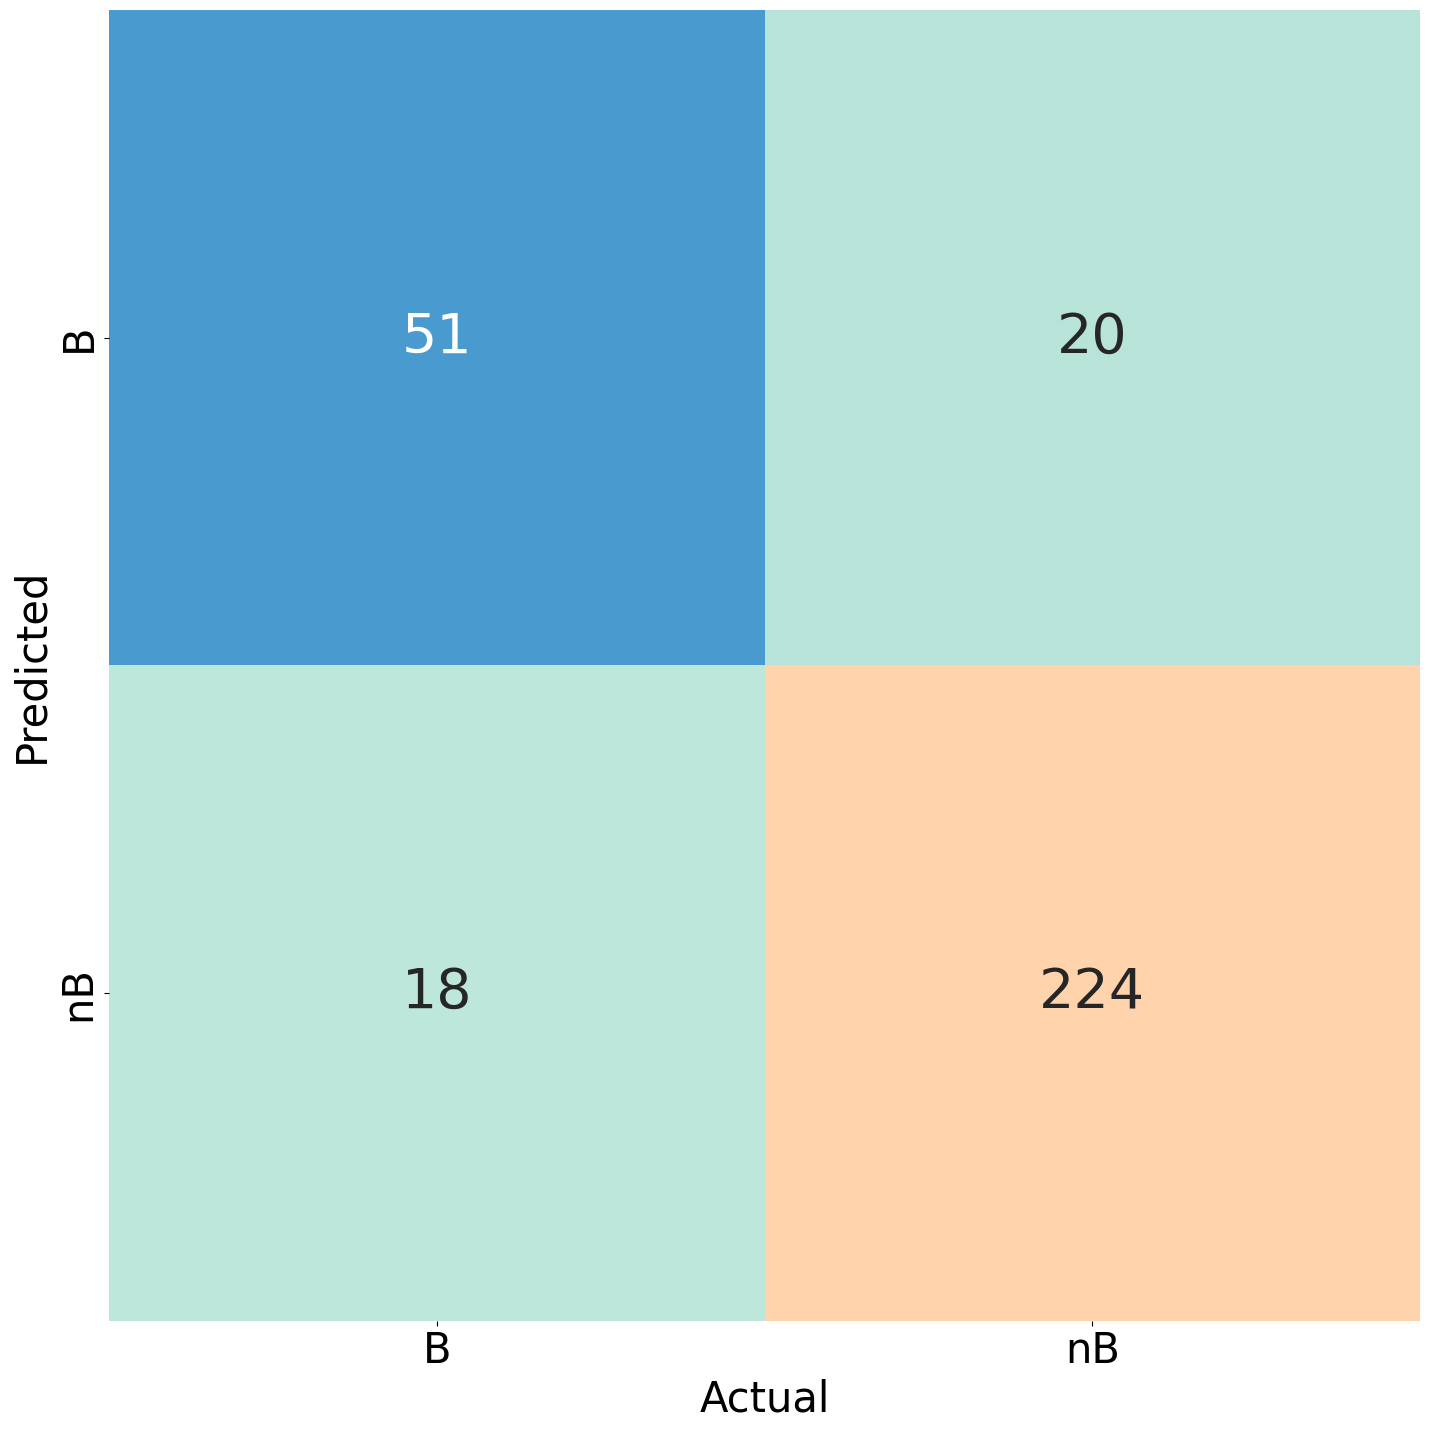

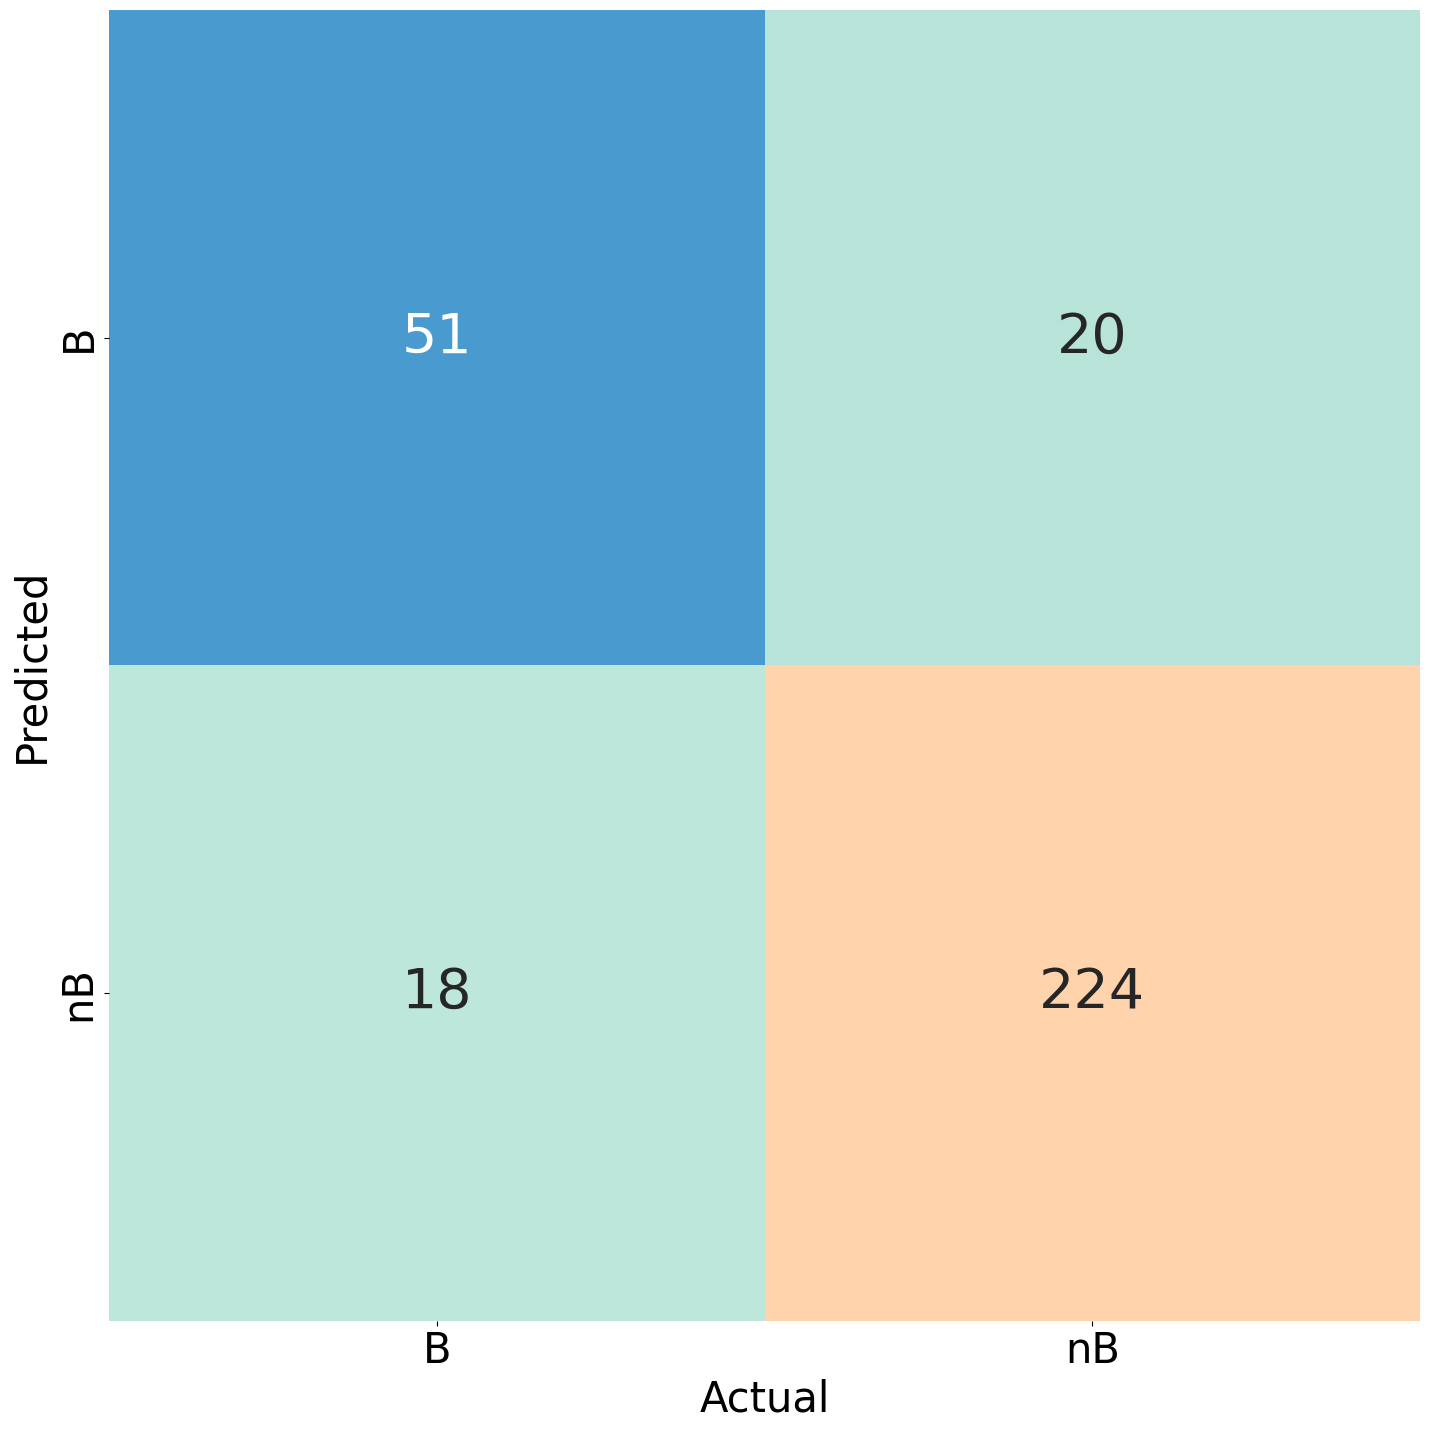

In [54]:
for conf_mat in conf_mats:
    rcParams["font.size"] = 30
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(
        conf_mat.ravel()[::-1].reshape((2,2)).T,
        annot=True,
        fmt=".3g",
        xticklabels=["B", "nB"],
        yticklabels=["B", "nB"],
        ax = ax,
        cbar = False,
        annot_kws={"fontsize": 40},
        cmap="icefire"
    )
    ax.set(
        ylabel="Predicted",
        xlabel="Actual"
    )
    plt.tight_layout()
    plt.show()

In [55]:
for conf_mat in conf_mats:
    tn, fp, fn, tp = conf_mat.ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    print("Specificity:", f"{specificity:.3}"," Sensitivity:", f"{sensitivity:.3}", "Accuracy", f"{accuracy:.3}", "Precision", f"{precision:.3}")


Specificity: 0.918  Sensitivity: 0.739 Accuracy 0.879 Precision 0.718
Specificity: 0.918  Sensitivity: 0.739 Accuracy 0.879 Precision 0.718
Specificity: 0.918  Sensitivity: 0.739 Accuracy 0.879 Precision 0.718
Specificity: 0.918  Sensitivity: 0.739 Accuracy 0.879 Precision 0.718
Specificity: 0.918  Sensitivity: 0.739 Accuracy 0.879 Precision 0.718
